In [1]:
import os
import random
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import nibabel as nib
import torch
from torch import optim
import torch.nn as nn
import torchvision
import torchio as tio

from tio_preprocessing import TIOPreprocessing

from model import UNet

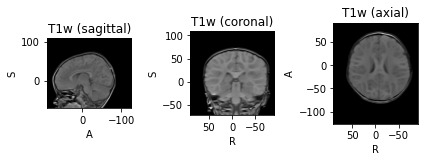

In [36]:
subject_path = '/home/faird/shared/projects/3D_MRI_GAN/tio_unet/data/sub-06IND001B_ses-001_desc-denoiseN4biasReg_T1w.nii.gz'

new_subject = tio.Subject(T1w=tio.ScalarImage(subject_path))

new_subject.plot()


In [3]:
def plot_histogram(axis, tensor, num_positions=100, label=None, alpha=0.05, color=None):
    values = tensor.numpy().ravel()
    kernel = stats.gaussian_kde(values)
    positions = np.linspace(values.min(), values.max(), num=num_positions)
    histogram = kernel(positions)
    kwargs = dict(linewidth=1, color='black' if color is None else color, alpha=alpha)
    if label is not None:
        kwargs['label'] = label
    axis.plot(positions, histogram, **kwargs)

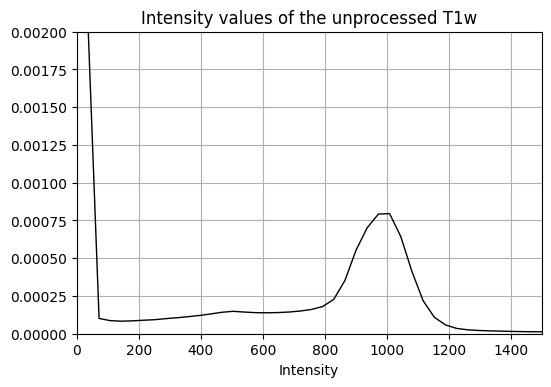

In [37]:
fig, ax = plt.subplots(dpi=100)
T1w_tensor = new_subject.T1w.data
plot_histogram(ax, T1w_tensor, alpha=1, color='black')
ax.set_xlim(0, 1500)
ax.set_ylim(0, 0.002)
ax.set_title('Intensity values of the unprocessed T1w')
ax.set_xlabel('Intensity')
ax.grid()
graph = None


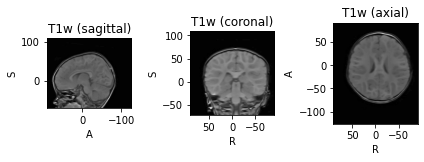

In [38]:
T1_landmarks = np.load('../T1w_landmarks.npy')
landmarks_dict = {'T1w': T1_landmarks}
histogram_transform = tio.HistogramStandardization(landmarks_dict)

standard = histogram_transform(new_subject)

standard.plot()


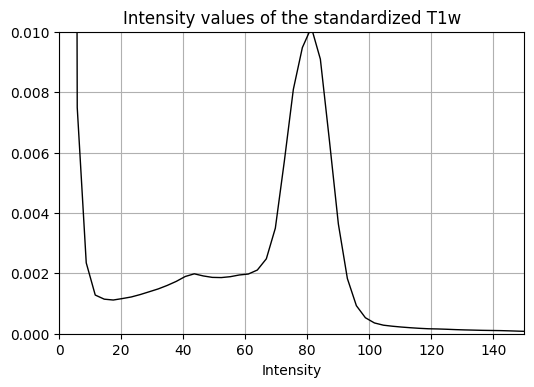

In [39]:
fig, ax = plt.subplots(dpi=100)
T1w_tensor = standard.T1w.data
plot_histogram(ax, T1w_tensor, alpha=1, color='black')
ax.set_xlim(0, 150)
ax.set_ylim(0, 0.01)
ax.set_title('Intensity values of the standardized T1w')
ax.set_xlabel('Intensity')
ax.grid()
graph = None

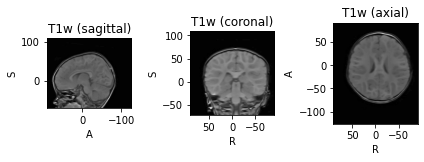

In [43]:
znorm_transform = tio.ZNormalization(masking_method=tio.ZNormalization.mean)

transform = tio.Compose([histogram_transform, znorm_transform])
#transform = tio.Compose([znorm_transform])
znormed = transform(new_subject)

znormed.plot()

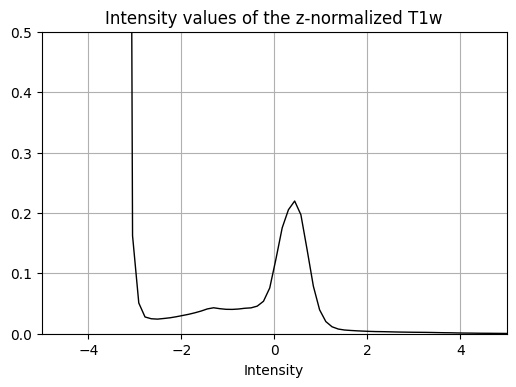

In [44]:
fig, ax = plt.subplots(dpi=100)
T1w_tensor = znormed.T1w.data
plot_histogram(ax, T1w_tensor, alpha=1, color='black')
ax.set_xlim(-5, 5)
ax.set_ylim(0, 0.5)
ax.set_title('Intensity values of the z-normalized T1w')
ax.set_xlabel('Intensity')
ax.grid()
graph = None

In [9]:
net = UNet()
device = torch.device("cpu")
net.load_state_dict(torch.load('trained_models/T1toT2_model_gpu_epoch-137.pth', map_location=device))


<All keys matched successfully>

In [42]:

patch_size = 100, 100, 100
patch_overlap = 10, 10, 10
grid_sampler = tio.inference.GridSampler(
    znormed,
    patch_size,
    patch_overlap,
)
patch_loader = torch.utils.data.DataLoader(
    grid_sampler, batch_size=1)
aggregator = tio.inference.GridAggregator(grid_sampler, overlap_mode='average')

net.eval()
with torch.no_grad():
    for patches_batch in patch_loader:
        inputs = patches_batch['T1w'][tio.DATA].to(device)
        locations = patches_batch[tio.LOCATION]
        pred_T2 = net(inputs)
        print(pred_T2.shape)
        aggregator.add_batch(pred_T2, locations)
        
prediction = aggregator.get_output_tensor()

torch.Size([1, 1, 100, 100, 100])
torch.Size([1, 1, 100, 100, 100])
torch.Size([1, 1, 100, 100, 100])
torch.Size([1, 1, 100, 100, 100])
torch.Size([1, 1, 100, 100, 100])
torch.Size([1, 1, 100, 100, 100])
torch.Size([1, 1, 100, 100, 100])
torch.Size([1, 1, 100, 100, 100])
torch.Size([1, 1, 100, 100, 100])
torch.Size([1, 1, 100, 100, 100])
torch.Size([1, 1, 100, 100, 100])
torch.Size([1, 1, 100, 100, 100])


In [35]:
prediction_data = prediction[0,:,:,:].data.numpy()
prediction_data = (prediction_data + prediction_data.min()) * 1400
img = nib.Nifti1Image(prediction_data, np.eye(4))
nib.save(img, 'predicted_T2_INDIA1.nii.gz') 

In [26]:
orig_data = znormed.T1w.data[0].numpy()
orig_data = (orig_data + orig_data.min()) * 1400
img = nib.Nifti1Image(orig_data, np.eye(4))
nib.save(img, 'input_T1_INDIA.nii.gz') 

In [12]:
prediction_data.min()

-3.2942934

In [19]:
orig_data.shape

(1, 117, 192, 192)

In [25]:
znormed.T1w.data[0].shape

torch.Size([117, 192, 192])

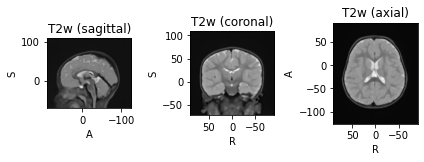

In [20]:
synth_T2_path = '/home/faird/shared/projects/3D_MRI_GAN/tio_unet/data/sub-100619_ses-17mo_T2w.nii.gz'

subject_T2 = tio.Subject(T2w=tio.ScalarImage(synth_T2_path))

subject_T2.plot()


In [25]:
std_T2 = tio.ToCanonical(subject_T2)
std_T2.plot()

ValueError: Probability must be a number in [0, 1], not Subject(Keys: ('T2w',); images: 1)

In [21]:
subject_T2.T2w.data[0].max()

tensor(1936.5482)

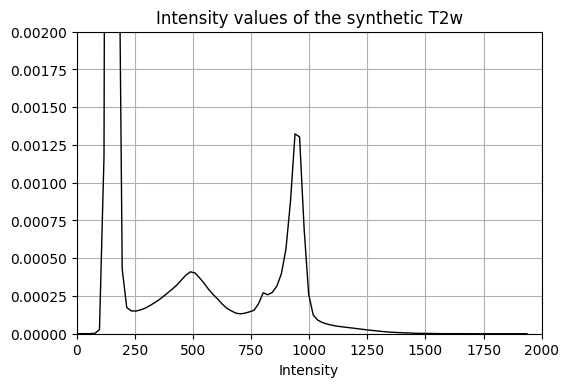

In [7]:
fig, ax = plt.subplots(dpi=100)
T2w_tensor = subject_T2.T2w.data
plot_histogram(ax, T2w_tensor, alpha=1, color='black')
ax.set_xlim(0, 2000)
ax.set_ylim(0, 0.002)
ax.set_title('Intensity values of the synthetic T2w')
ax.set_xlabel('Intensity')
ax.grid()
graph = None


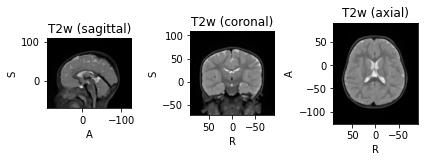

In [22]:
T2_landmarks = np.load('../T2w_landmarks.npy')
T2_landmarks_dict = {'T2w': T2_landmarks}
T2_histogram_transform = tio.HistogramStandardization(T2_landmarks_dict)

standard = T2_histogram_transform(subject_T2)

standard.plot()

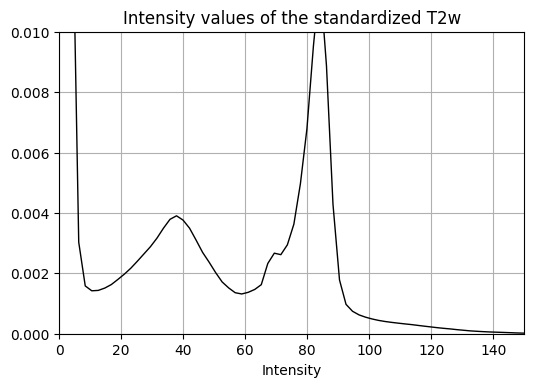

In [10]:
fig, ax = plt.subplots(dpi=100)
T2w_tensor = standard.T2w.data
plot_histogram(ax, T2w_tensor, alpha=1, color='black')
ax.set_xlim(0, 150)
ax.set_ylim(0, 0.01)
ax.set_title('Intensity values of the standardized T2w')
ax.set_xlabel('Intensity')
ax.grid()
graph = None

In [23]:
standard.T2w.data[0].shape

orig = nib.load('/home/faird/shared/projects/3D_MRI_GAN/tio_unet/data/sub-100619_ses-17mo_T2w.nii.gz')
new = nib.Nifti1Image(standard.T2w.data[0].numpy(), orig.affine)
nib.save(new, '/home/faird/shared/projects/3D_MRI_GAN/tio_unet/sub-100619_ses-17mo_T2w.nii.gz')

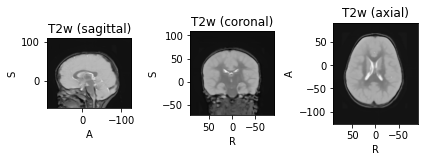

In [38]:
synth_T2_path = '/home/faird/shared/projects/3D_MRI_GAN/tio_unet/data/sub-06IND003G_ses-003_T2w.nii.gz'

subject_T2 = tio.Subject(T2w=tio.ScalarImage(synth_T2_path))

subject_T2.plot()

In [39]:
subject_T2.T2w.data[0].max()

tensor(26397.5215)

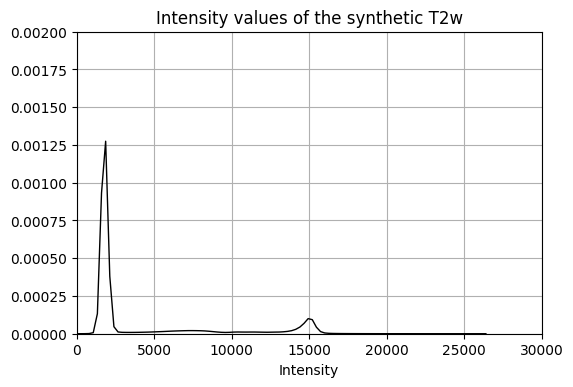

In [40]:
fig, ax = plt.subplots(dpi=100)
T2w_tensor = subject_T2.T2w.data
plot_histogram(ax, T2w_tensor, alpha=1, color='black')
ax.set_xlim(0, 30000)
ax.set_ylim(0, 0.002)
ax.set_title('Intensity values of the synthetic T2w')
ax.set_xlabel('Intensity')
ax.grid()
graph = None


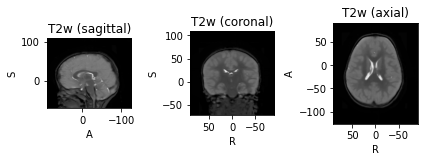

In [41]:
T2_landmarks = np.load('../T2w_landmarks.npy')
T2_landmarks_dict = {'T2w': T2_landmarks}
T2_histogram_transform = tio.HistogramStandardization(T2_landmarks_dict)

standard = T2_histogram_transform(subject_T2)

standard.plot()

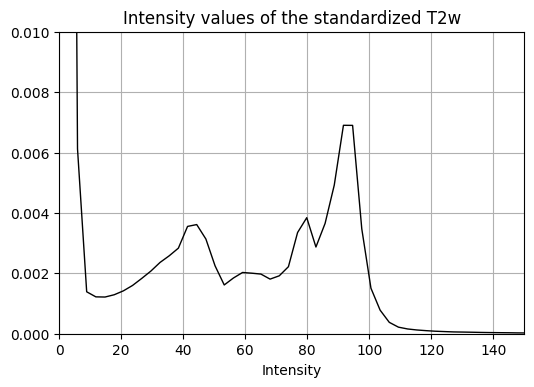

In [42]:
fig, ax = plt.subplots(dpi=100)
T2w_tensor = standard.T2w.data
plot_histogram(ax, T2w_tensor, alpha=1, color='black')
ax.set_xlim(0, 150)
ax.set_ylim(0, 0.01)
ax.set_title('Intensity values of the standardized T2w')
ax.set_xlabel('Intensity')
ax.grid()
graph = None

In [43]:
standard.T2w.data[0].shape

orig = nib.load('/home/faird/shared/projects/3D_MRI_GAN/tio_unet/data/sub-06IND003G_ses-003_T2w.nii.gz')
new = nib.Nifti1Image(standard.T2w.data[0].numpy(), orig.affine)
nib.save(new, '/home/faird/shared/projects/3D_MRI_GAN/tio_unet/sub-06IND003G_ses-003_T2w.nii.gz')